In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import farid

from pyextal.dinfo import CBEDDiffractionInfo, LARBEDDiffractionInfo
from pyextal.roi import CBEDROI, LARBEDROI
from pyextal.optimize import CoarseOptimize, FineOptimize
from pyextal.gof import Chi2_LARBED

# from pyextal.dinfo import CBEDDiffractionInfo, LARBEDDiffractionInfo
# from pyextal.roi import CBEDROI, LARBEDROI
# from pyextal.optimize import CoarseOptimize, FineOptimize
# from pyextal.gof import Chi2_LARBED

import mpi4py.MPI as MPI





pyextal package imported. Version: 0.0.1


This is not an entirely automated process. Several steps will take time to adjust and hone in to get accurate results. Particularly for off-axis LARBED. Disk descriptions(gl, allshift, alignment, etc) can be quite difficult to get accurate results. Some manual adjustments may be necessary.

In [2]:
plt.rcParams['image.cmap'] = 'inferno'

# load Larbed data
1. load the image stack
2. load the indexing
3. display the data (optional)

In [3]:
dp = np.load("../Larbed/Si_undoped/111_110sys/region1/Store_deconv.npy")
dp = np.flip(dp,axis=2)
gindex = np.load("../Larbed/Si_undoped/111_110sys/region1/g_vectorsSi.npy")
variance = np.load("../Larbed/Si_undoped/111_110sys/region1/Store_variance.npy")
variance = np.flip(variance,axis=2)
#data = np.delete(data,[1,4,5,7,8],axis=0)
#gindex = np.delete(gindex,[1,4,5,7,8],axis=0)

# dp = np.asarray(data,dtype=np.float32)

'''
fig, axs = plt.subplots(len(data)//4 + 1, 4, figsize=(10, 10*len(data)//12))

for i in range(len(data)):
    row = i // 4
    col = i % 4
    axs[row, col].imshow(data[i],vmin=1e4,vmax=1e5)
    axs[row, col].set_title("Index Number "+str(i)+" : "+str(gindex[i]))
plt.tight_layout()
plt.show()'''


'\nfig, axs = plt.subplots(len(data)//4 + 1, 4, figsize=(10, 10*len(data)//12))\n\nfor i in range(len(data)):\n    row = i // 4\n    col = i % 4\n    axs[row, col].imshow(data[i],vmin=1e4,vmax=1e5)\n    axs[row, col].set_title("Index Number "+str(i)+" : "+str(gindex[i]))\nplt.tight_layout()\nplt.show()'

# set detector parameters
- I'm not sure what Detector perameters we will need to add for the LARBED data.
For now set all values to 1

In [4]:
dtpar = [0,0,0,0,0]
background = 0

In [5]:
dp[dp < 1] = 1

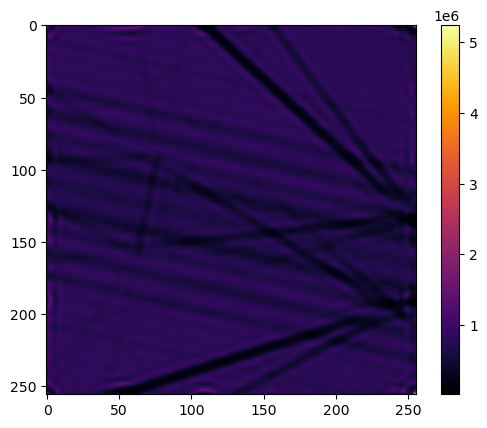

In [6]:
plt.imshow(dp[10])
plt.colorbar()

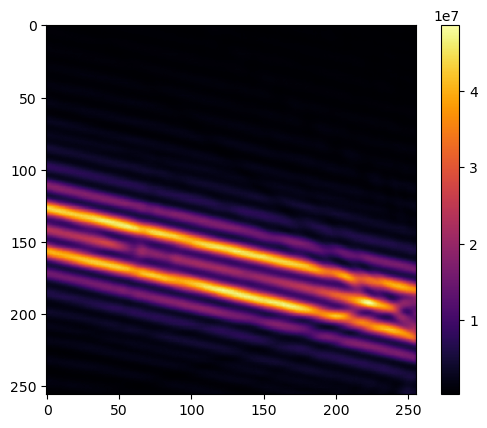

In [7]:
plt.imshow(variance[4])
plt.colorbar()

In [8]:
dinfo = LARBEDDiffractionInfo(dp,  900,  0, 0, 31.78, 'Si_undoped/si111_110sys.dat', dtpar, background,gindex, varianceMaps=variance)
#dinfo = LARBEDDiffractionInfo(dp,  859.95800882591936,  0, 0, 39, 'examples/Cu2O/ZSM5.dat', dtpar, background,gindex)
#np.flip(dp[31],axis=1)
#print(dinfo.dp[23])
#print(dinfo.gindex)

# region of interest parameters:
defines the region of interest for refinement
- rotation: relative to the xaxis set in .dat
- nthgx: which hkl relative to the xaxis set in .dat
- dpCenter: of diffraction pattern for simulation as reference point
- dpSize: size of the diffraction pattern for simulation

In [9]:
# rotation = 74+180
rotation = -112.07+35.1+180
nthgx = [0,0,0]
# dpCenter = [153, 160]
dpCenter = [127, 127]
# dpSize = [256,256]
dpSize = [255,255]
dp_index = 0
sim_index = 0
gInclude = [(0,0,0),(2,-2,0), (-2,2,0)]

In [10]:
roi = LARBEDROI(dinfo=dinfo, rotation=rotation, gx=np.array([1,-1,0]), gInclude=gInclude) 
print(sim_index, dp_index)
print(gindex[dp_index])
#print(roi.dinfo.lastParam)


include beam initialized
group symmetry initialized
0 0
[-4  4  0]


After you find a LARBED area that matches pull out the hkl and manually inset them into the dat file. This will fix discrepencies with missing beams later

ROI MUST BE SYMMETRIC or the refined position will not align the simulation with the experimental data adjust dpcenter if the roi is clipping

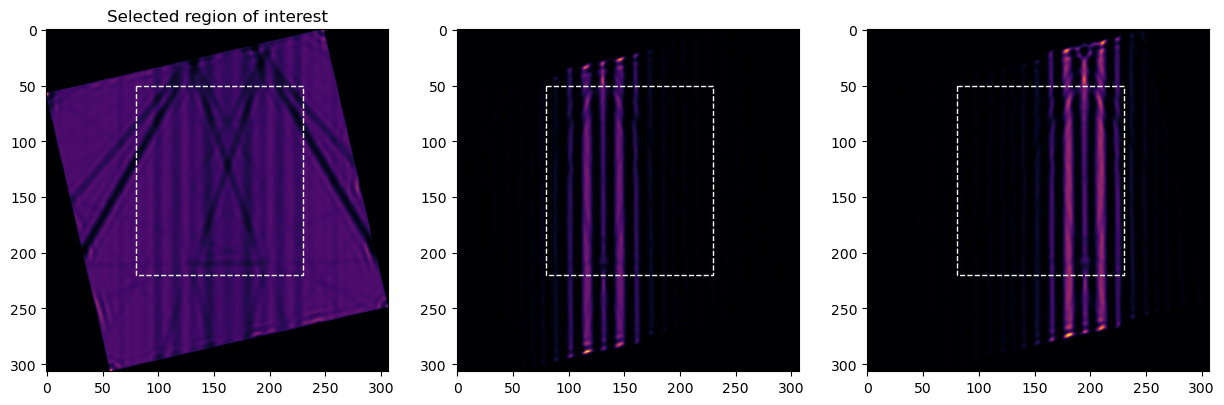

In [11]:
roi.selectROI(np.array([[[50,80], [50, 230], [220,80], [150,170]]]))
roi.displayROI()



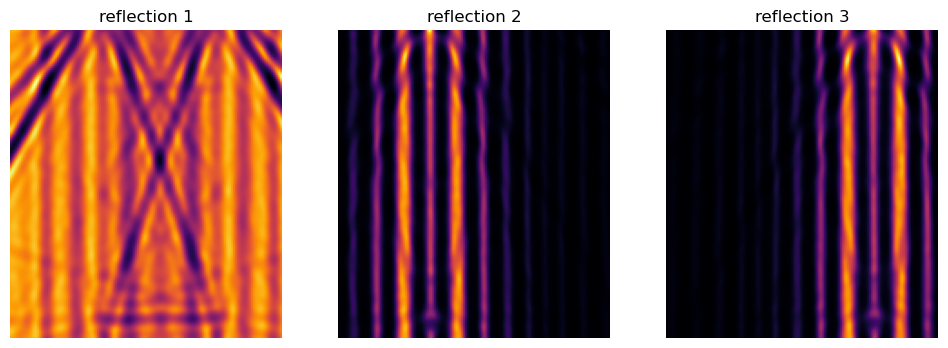

In [12]:
coarse = CoarseOptimize(datpath='Si_undoped/si111_110sys.dat', dinfo=dinfo, roi=roi)

In [13]:
coarse.optimizeOrientationThickness()


Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol = 0.001 )
thickness: 937.452308051833, gl: 31.78, tiltY: 0.13294736262829376, tiltX: 0.08710344448060625


IF THE COARSE SEARCH IS WAY OFF YOU NEED TO FIX TILT, ROTATION, OR ADJUST GL

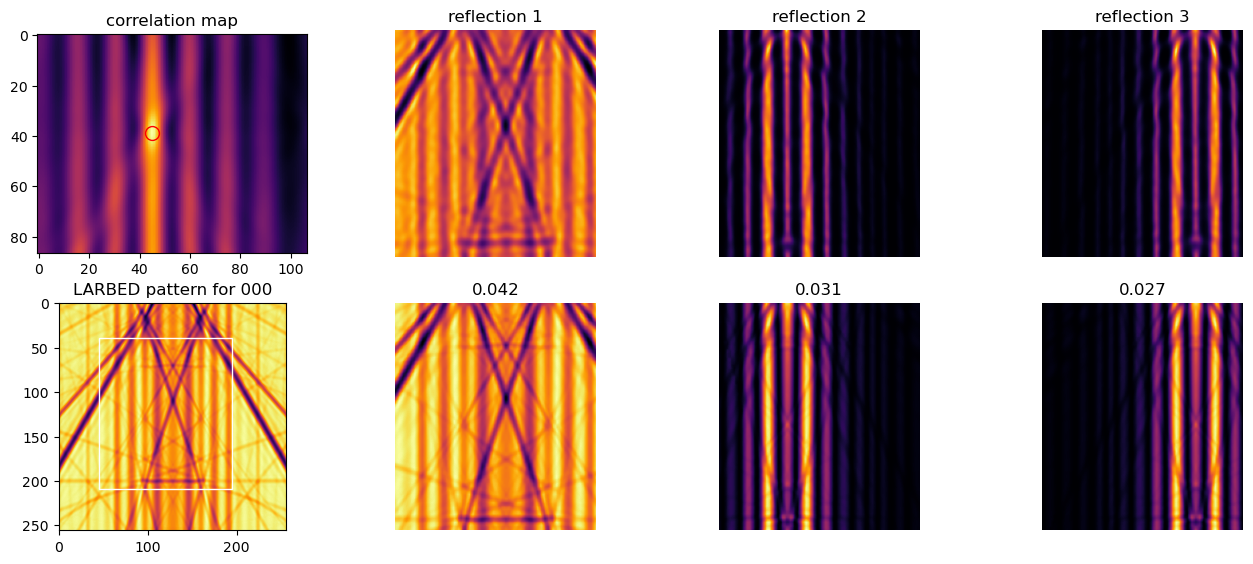

In [14]:
coarse.displayCoarseSearch()

In [15]:
reflection_list = []
reflection_list = [(2,-2,0),]
print(reflection_list)

[(2, -2, 0)]


Sometimes ROI is flipping when moving from coarse to fine. Im not sure where this bug is. Trying to find it. For now inverting the ROI works

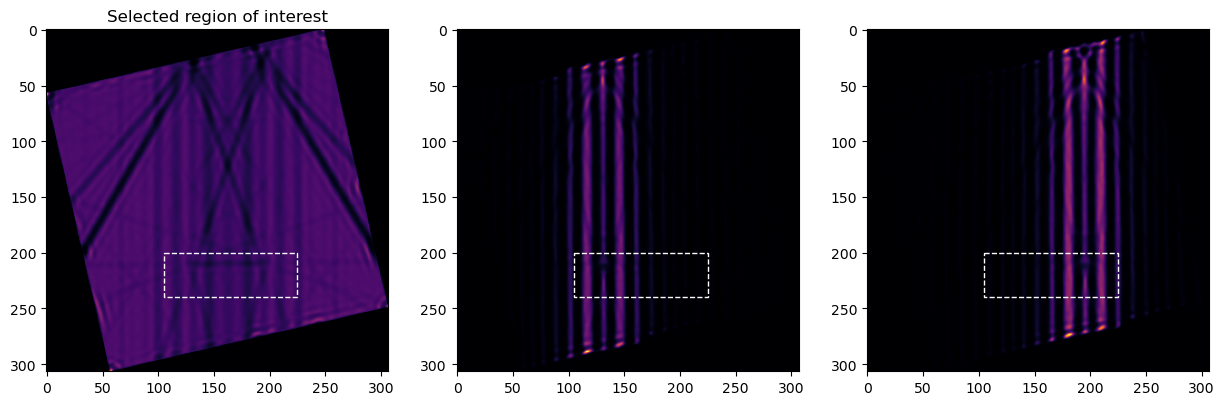

In [16]:

# roi.selectROI(np.array([[[-70,-40], [-70, -30], [0,-50], [60,25]],
#                         [[-55,-75],[-55, -25], [65,-75], [60,25]],
                        
#                         ],), 
#               mask=np.array([[0,1,1,0,0,1,0,0,0],
#                              [0,0,0,1,1,0,1,0,0],
                        
#                              ]))                        
# roi.selectROI(np.array([[[50,50], [50,250], [250, 50], [30,30]]]))
roi.selectROI(np.array([[[200,105], [200,225], [240, 105], [60,20]]]))

# roi.selectROI(np.array([[[-50,-100], [-50, 100], [-10,-100], [50,10]],
#                         [[20,-100], [20, 100], [60,-100], [50,10]]]),
#                         mask=np.array([[0,0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,0,1] ]))
roi.displayROI()


In [17]:
fine = FineOptimize(dinfo=dinfo,
                    roi=roi,
                    reflections=reflection_list,
                    sfMask=np.array([[True, True]]),
                    errorFunc=Chi2_LARBED(roi=roi),
                    perturbROI=True,
                    symUpdate=True)

In [18]:
from pyextal.callBloch import lookupSF
temp = lookupSF(reflection_list)

# temp[1] = np.array([0.0005,0,1e-36,180])
# print(temp)

# tempRange = np.array([temp*0.90, temp*1.10])
# print(tempRange)

In [19]:
temp

array([[4.5695696e-02, 0.0000000e+00, 7.3504535e-04, 1.8000000e+02]],
      dtype=float32)

In [20]:
tempRange = np.array([[[5.0623707e-02, 0.0000000e+00, 5.4254957e-04, 1.8000000e+02],
                      [5.0000002e-04, 0.0000000e+00, 0.9000000e-36, 1.8000000e+02]],
                      [[5.5623707e-02, 0.0000000e+00, 5.8254957e-04, 1.8000000e+02],
                      [5.5000002e-04, 0.0000000e+00, 1.1000000e-36, 1.8000000e+02]]
                      ])
print(tempRange)

[[[5.0623707e-02 0.0000000e+00 5.4254957e-04 1.8000000e+02]
  [5.0000002e-04 0.0000000e+00 9.0000000e-37 1.8000000e+02]]

 [[5.5623707e-02 0.0000000e+00 5.8254957e-04 1.8000000e+02]
  [5.5000002e-04 0.0000000e+00 1.1000000e-36 1.8000000e+02]]]


(2, -2, 0): U 0.0456957 UA 0.0007350
Chi Square single bacckground LARBED: 130.76668


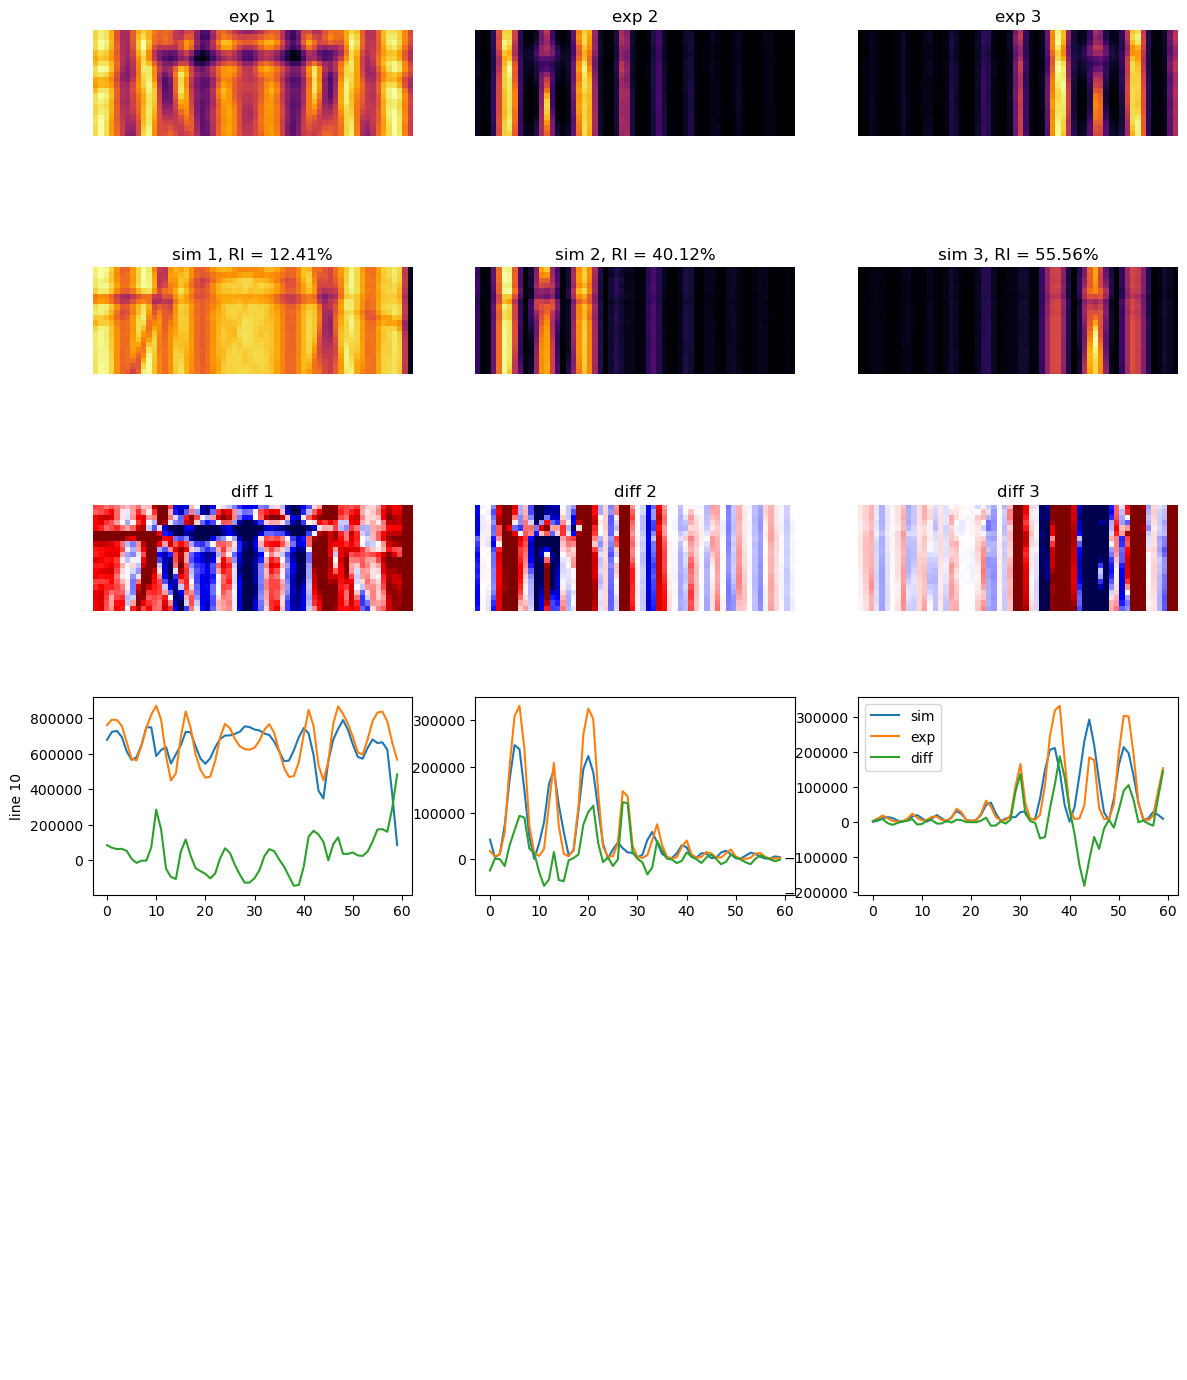

In [19]:
fine.getx0()
# fine.getRange()
fine.display([10,20,30])

In [20]:
%matplotlib qt
#roi.gl = 37.76466
#roi.sigma =roi.sigma*5

fine.optimize()
#fine.optimize(np.array([[1.0, 1.0],[1.0, 1.0],[1.0, 1.0],[1.0, 1.0]]))
# fine.optimize()

setting the initial value and normalization range to:
beam: (2, -2, 0)
      lower       value       upper  
U : 4.3410912e-02   4.5695696e-02   4.7980480e-02
UA: 6.9829309e-04   7.3504535e-04   7.7179761e-04
------------------------------


MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


start optimization
normal:[[0.0456957  0.00073505]]
SF:
(2, -2, 0): 4.5695696e-02 7.3504535e-04
thickness: 961.22 gl: 32.42051 rotation: 103.47981
corner: -0.19973 5.08985
GOF: 105.20133  func eval: 254
Error: 104.99677083333333  func eval: 254
********************
SF:
(2, -2, 0): 4.5809935e-02 7.3504535e-04
thickness: 960.08 gl: 32.42452 rotation: 103.47711
corner: -0.23289 5.07131
GOF: 104.00497  func eval: 76
Error: 103.80274305555555  func eval: 76
********************
SF:
(2, -2, 0): 4.5695696e-02 7.3688297e-04
thickness: 962.09 gl: 32.43735 rotation: 103.46638
corner: -0.31489 5.14813
GOF: 105.13966  func eval: 109
Error: 104.93522569444444  func eval: 109
********************
SF:
(2, -2, 0): 4.5809935e-02 7.3688297e-04
thickness: 960.24 gl: 32.44033 rotation: 103.45856
corner: -0.35005 5.19822
GOF: 103.94411  func eval: 77
Error: 103.74199652777777  func eval: 77
********************
SF:
(2, -2, 0): 4.5867055e-02 7.3780177e-04
thickness: 959.36 gl: 32.44433 rotation: 103.45162
c

(2, -2, 0): U 0.0494834 UA 0.0007447
Chi Square single bacckground LARBED: 83.25704


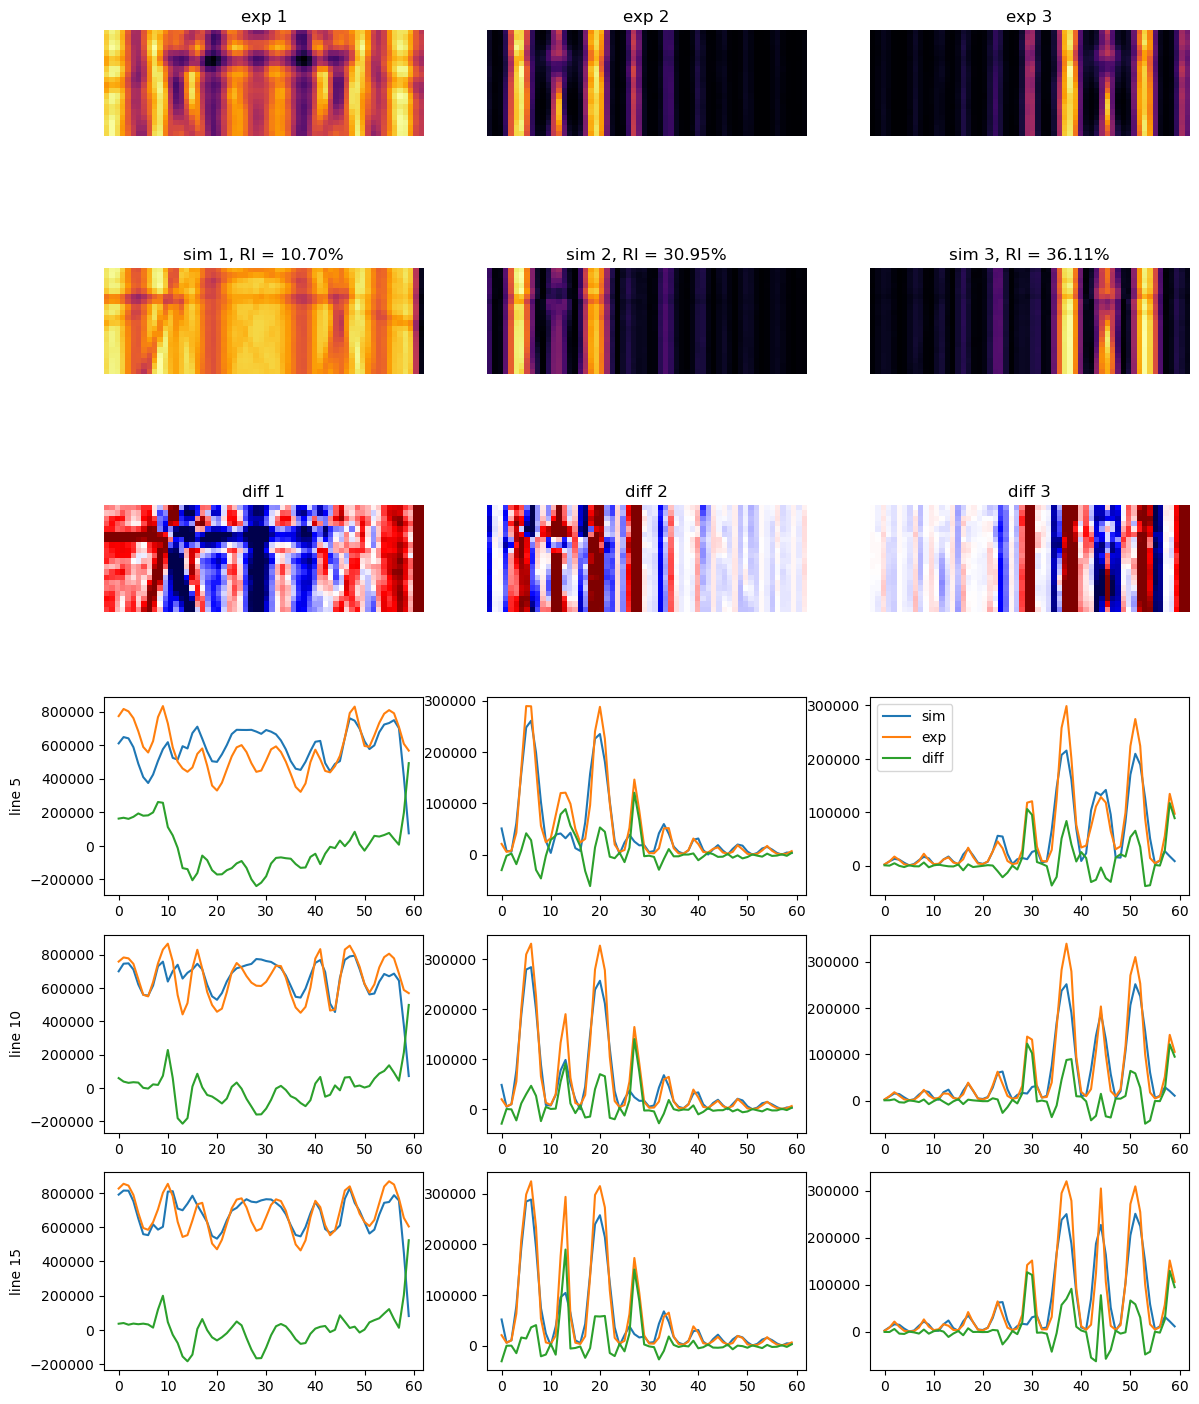

In [21]:
%matplotlib inline

fine.display([5,10,15])

In [22]:

print(f'gl: {roi.gl} rotation: {roi.rotation}\n')
print(f'thickness: {fine.thickness}\n')
print(f'norm: {fine.errorFunc.scale}\n')
print(f'background: {fine.errorFunc.background}\n')

gl: 32.16799102344274 rotation: 102.6873512585758

thickness: 923.0978589425227

norm: 843407.8537619084

background: 73.9780781199051

